In [9]:
%matplotlib inline

# Segment the tissue in TEMCA optical images

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import boto3
import skimage.io as io
import skimage
from skimage import data
from skimage import feature
from skimage import color
from skimage import filters
from skimage import transform 
from skimage import draw
from skimage import measure
from skimage import morphology
import skdemo
from scipy import ndimage as ndi
from toolbox.TAO.tao import TAO
from toolbox.TAO.taoDB import TAOdb

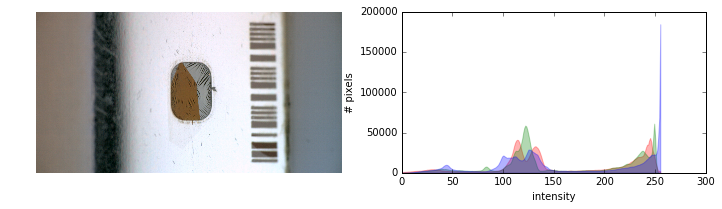

In [11]:
# get an image
tao =  TAO()
taoDB = TAOdb()
url = taoDB.get_aperture_image_url('donaldtrump', 'test1', '000040')
im = io.imread(url)
skdemo.imshow_with_histogram(im);

In [12]:
# crop the image to the interesting part, convert to HSV
xoff = 700
imc = im[:, xoff:1300, :]
#print (imc.dtype, imc.max())
imhsv = color.rgb2hsv(imc)
imgray = color.rgb2gray(imc)
print (imgray.dtype, imgray.max())


(dtype('float64'), 0.99552784313725495)


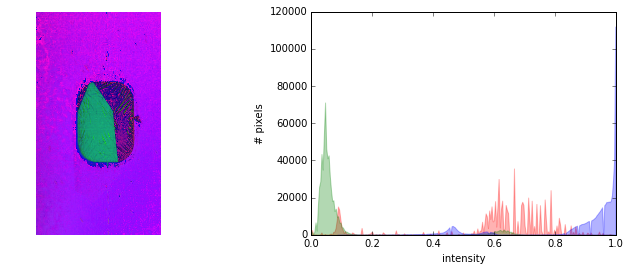

In [13]:
skdemo.imshow_with_histogram(imhsv);

0.393942808494


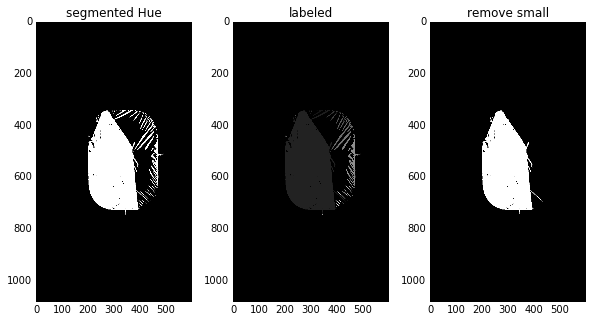

In [14]:
#convert to HSV space
imv = imhsv[:,:,0]
threshold = filters.threshold_otsu(imv )
print threshold
imb = imgray < threshold
imlabel = morphology.label(imb)
imnosmall = morphology.remove_small_objects(imlabel, min_size=4000, connectivity=1, in_place=False)

fig, (ax_1, ax_2, ax_3) = plt.subplots(ncols=3, figsize=(10, 5))
ax_1.imshow(imb, cmap='gray')
ax_1.set_title('segmented Hue')
ax_2.imshow(imlabel, cmap='gray')
ax_2.set_title('labeled')
ax_3.imshow(imnosmall, cmap='gray')
ax_3.set_title('remove small')


(dtype('int64'), 8, (1080L, 600L))
(dtype('uint8'), 254, (1080L, 600L))


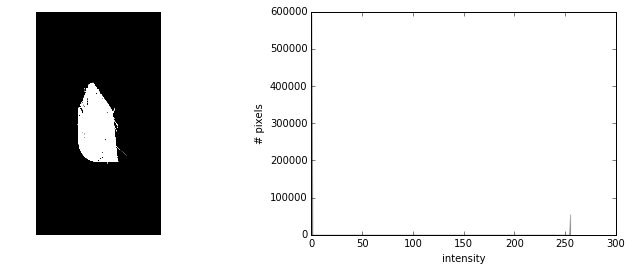

In [15]:
print (imnosmall.dtype, imnosmall.max(), imnosmall.shape)
image = skimage.img_as_ubyte(imgray)
print (image.dtype, image.max(), image.shape)
image[:,:] = 0
image[imnosmall != 0] = 255
skdemo.imshow_with_histogram(image);

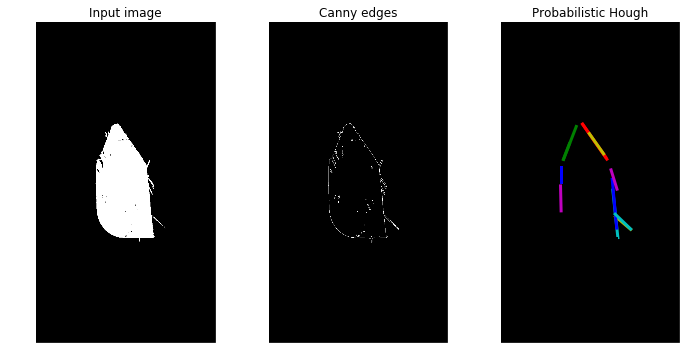

In [18]:
# Line finding using the Probabilistic Hough Transform.
edges = feature.canny(image)
lines = transform.probabilistic_hough_line(edges)

# Generating figure 2.
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 5), sharex=True,
                                    sharey=True)
plt.tight_layout()

ax0.imshow(image, 'gray')
ax0.set_title('Input image')
ax0.set_axis_off()
ax0.set_adjustable('box-forced')

ax1.imshow(edges, 'gray')
ax1.set_title('Canny edges')
ax1.set_axis_off()
ax1.set_adjustable('box-forced')

ax2.imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax2.plot((p0[0], p1[0]), (p0[1], p1[1]), linewidth=3.0)

row2, col2 = image.shape
ax2.axis((0, col2, row2, 0))

ax2.set_title('Probabilistic Hough')
ax2.set_axis_off()
ax2.set_adjustable('box-forced')

plt.show()